In [1]:
import pandas_datareader.data as web
import statsmodels.tsa.api as tsa
import matplotlib.pyplot as plt
import numpy as np

# Decompose Time-Series Patterns

Use monthly data on industrial manufacturing production.

In [2]:
industrial_production = web.DataReader('IPGMFN', 'fred', '1988', '2017-12').squeeze()
industrial_production.head()

DATE
1988-01-01    56.7982
1988-02-01    58.0084
1988-03-01    58.6871
1988-04-01    58.9176
1988-05-01    59.0147
Name: IPGMFN, dtype: float64

/Users/pasin/opt/anaconda3/envs/env01/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


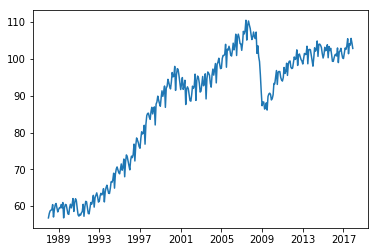

In [3]:
plt.plot(industrial_production)
plt.show()

The series seems to have a stable variance, but it has a trend. Thus, we should use an additive decomposition model.

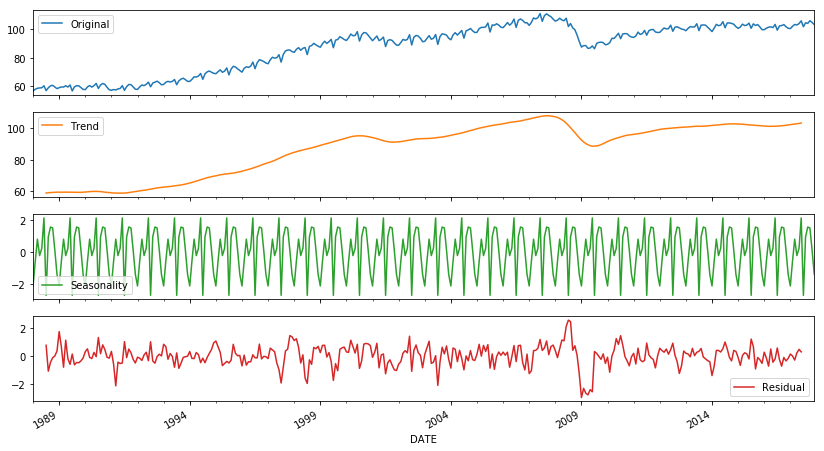

In [4]:
components = tsa.seasonal_decompose(industrial_production, model = 'additive')
ts = (industrial_production.to_frame('Original').assign(Trend = components.trend).assign(Seasonality = components.seasonal).assign(Residual = components.resid))
ts.plot(subplots = True, figsize = (14,8))
plt.show()

## Correlogram

In [6]:
from statsmodels.graphics.tsaplots import plot_acf, acf, plot_pacf, pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from scipy.stats import moment, probplot

In [7]:
def correlogram(x, lags = None, title = None):
    lags = min(10, int(len(x)/5)) if lags is None else lags
    fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (14,8))
    x.plot(ax = axes[0][0])
    q_p = np.max(q_stat(acf(x, nlags = lags), len(x))[1])
    stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f}'
    axes[0][0].text(x=.02, y=.85, s = stats, transform = axes[0][0].transAxes)
    probplot(x, plot = axes[0][1])
    mean, var, skew, kurtosis = moment(x, moment = [1,2,3,4])
    s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
    axes[0][1].text(x=.02, y=.75, s=s, transform = axes[0][1].transAxes)
    plot_acf(x=x, lags=lags, zero = False, ax = axes[1][0])
    plot_pacf(x, lags = lags, zero = False, ax = axes[1][1])
    axes[1][0].set_xlabel('Lag')
    axes[1][1].set_xlabel('Lag')
    fig.suptitle(title, fontsize = 20)
    fig.tight_layout()
    fig.subplots_adjust(top=.9)

/Users/pasin/opt/anaconda3/envs/env01/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


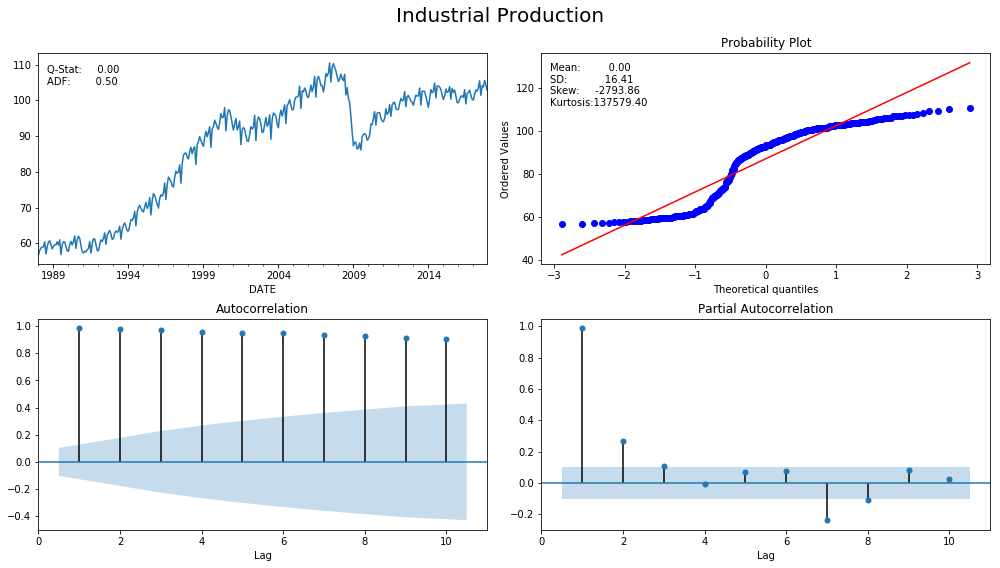

In [8]:
correlogram(industrial_production, title = 'Industrial Production')

Seasonal log-diff

In [9]:
industrial_production_log_diff = (np.log(industrial_production)).diff(12).dropna()

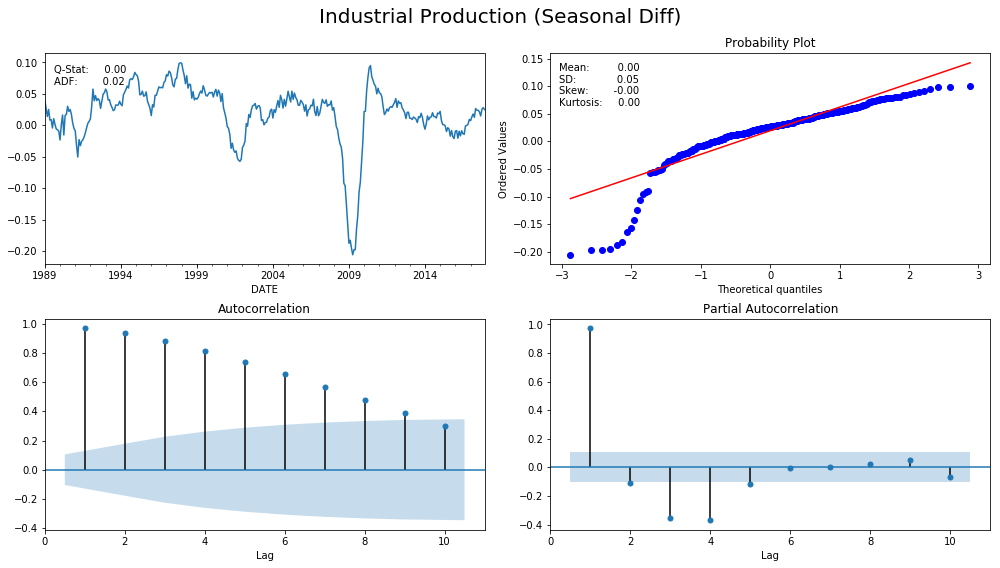

In [10]:
correlogram(industrial_production_log_diff, title = 'Industrial Production (Seasonal Diff)')

# Univariate Time-Series 

## ARMA and ARIMA

In [12]:
arma_model = tsa.ARMA(endog = industrial_production_log_diff, order = (2,2)).fit()
arima_model = tsa.ARIMA(endog = industrial_production_log_diff, order = (2,1,2)).fit()

/Users/pasin/opt/anaconda3/envs/env01/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/pasin/opt/anaconda3/envs/env01/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/pasin/opt/anaconda3/envs/env01/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [13]:
arma_model.params.sort_index() == arima_model.params.sort_index().values

ar.L1.IPGMFN    False
ar.L2.IPGMFN    False
const           False
ma.L1.IPGMFN    False
ma.L2.IPGMFN    False
dtype: bool

## Seasonal Differencing and SARIMAX

Compare two models. The first one is SARIMAX with original data and diff in seasonal order, the other is SARIMAX with the log-diff data without diff in seasonal order.

In [14]:
sar1 = tsa.statespace.SARIMAX(np.log(industrial_production), order = (2,0,2), seasonal_order=(0,1,0,12)).fit()
sar2 = tsa.statespace.SARIMAX(industrial_production_log_diff, order = (2,0,2), seasonal_order=(0,0,0,12)).fit()

/Users/pasin/opt/anaconda3/envs/env01/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/pasin/opt/anaconda3/envs/env01/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/pasin/opt/anaconda3/envs/env01/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/pasin/opt/anaconda3/envs/env01/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [15]:
sar1.params.to_frame('SARIMAX').join(sar2.params.to_frame('diff'))

,SARIMAX,diff
ar.L1,1.761975,1.765978
ar.L2,-0.784199,-0.788255
ma.L1,-0.841204,-0.859608
ma.L2,0.313330,0.353158
sigma2,0.000101,0.000101


## Finding the optimal ARMA lags

In [16]:
from numpy.linalg import LinAlgError
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')
import pandas as pd

In [17]:
train_size = 120
test_results = {}
y_true = industrial_production_log_diff.iloc[train_size:]
for p in range(5):
    for q in range(5):
        aic, bic = [], []
        if p == 0 and q == 0:
            continue
        print(p,q)
        convergence_error = stationarity_error = 0
        y_pred = []
        for T in range(train_size, len(industrial_production_log_diff)):
            train_set = industrial_production_log_diff.iloc[T - train_size:T]
            try:
                model = tsa.ARMA(endog = train_set, order = (p,q)).fit()
            except LinAlgError:
                convergence_error += 1
            except ValueError:
                stationarity_error += 1
            
            forecast, _, _ = model.forecast(steps = 1)
            y_pred.append(forecast[0])
            aic.append(model.aic)
            bic.append(model.bic)
        
        result = (pd.DataFrame({'y_true': y_true, 'y_pred': y_pred}).replace(np.inf, np.nan).dropna())
        rmse = np.sqrt(mean_squared_error(result.y_true, result.y_pred))
        test_results[(p,q)] = [rmse, np.mean(aic), np.mean(bic), convergence_error, stationarity_error]

0 1
0 2
0 3
0 4
1 0
1 1
1 2
1 3
1 4
2 0
2 1
2 2
2 3
2 4
3 0
3 1
3 2
3 3
3 4
4 0
4 1
4 2
4 3
4 4


In [26]:
test_results = pd.DataFrame(test_results).T
test_results.columns = ['RMSE', 'AIC', 'BIC', 'convergence', 'stationarity']
test_results.index.names = ['p', 'q']
test_results.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 24 entries, (0, 1) to (4, 4)
Data columns (total 5 columns):
RMSE            24 non-null float64
AIC             24 non-null float64
BIC             24 non-null float64
convergence     24 non-null float64
stationarity    24 non-null float64
dtypes: float64(5)
memory usage: 1.2 KB


In [27]:
test_results.dropna()

RMSE         AIC         BIC  convergence  stationarity
p q                                                              
0 1   0.030183 -530.769444 -522.406969          0.0           0.0
  2   0.097291 -586.207104 -575.057137          0.0         102.0
  3   0.124803 -660.449815 -646.512356          0.0         182.0
  4   0.136629 -678.167783 -661.577317          0.0         206.0
1 0   0.011551 -727.389093 -719.026618          0.0           0.0
  1   0.029556 -732.051839 -720.901872          0.0          16.0
  2   0.021869 -743.997434 -730.059975          0.0          10.0
  3   0.018212 -747.753733 -731.028783          0.0           8.0
  4   0.018165 -753.080599 -733.568157          0.0           8.0
2 0  24.970287 -722.752973 -711.603006          0.0           0.0
  1   0.032027 -746.832902 -732.895443          7.0          17.0
  2   0.012665 -758.392467 -741.667516          0.0           4.0
  3   0.011622 -759.908808 -740.396365          1.0           3.0
  4   0.043273 -758.542041 -736.242107          0.0          24.0
3 0   0.010585 -747.347746 -733.410287          0.0           0.0
  1   0.011228 -754.402501 -737.677551          0.0           5.0
  2   0.011957 -757.496657 -737.984215          4.0           5.0
  3   0.009757 -759.080171 -736.780237          2.0          16.0
  4   0.043026 -762.626332 -737.538906          1.0          57.0
4 0   0.010008 -758.715127 -741.990177          0.0           0.0
  1   0.010033 -759.113002 -739.600560          0.0           2.0
  2   0.013713 -759.329203 -737.029269          0.0           4.0
  3   0.030599 -761.639373 -736.551947          1.0          41.0
  4   0.029911 -760.304886 -732.429969          2.0          60.0

Remember that the goal is to minimize RMSE, The heatmap should help us visualizing the result.

In [29]:
import seaborn as sns

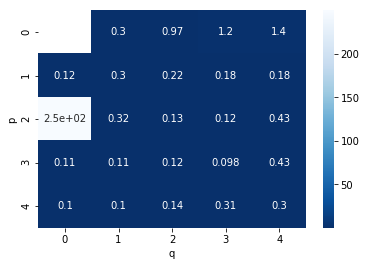

In [31]:
sns.heatmap(test_results.RMSE.unstack().mul(10), fmt = '.2', annot=True, cmap = 'Blues_r')
plt.show()

We also aim to minimize BIC:

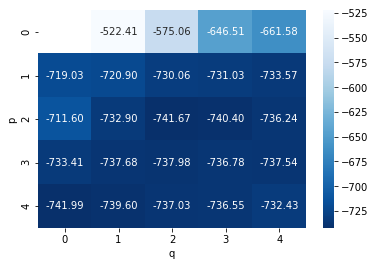

In [33]:
sns.heatmap(test_results.BIC.unstack(), fmt = '.2f', annot = True, cmap = 'Blues_r')
plt.show()

# Try ARMA(1,3)

In [35]:
model = tsa.ARMA(endog = industrial_production_log_diff, order = (1,3)).fit()
print(model.summary())

                              ARMA Model Results                              
Dep. Variable:                 IPGMFN   No. Observations:                  348
Model:                     ARMA(1, 3)   Log Likelihood                1094.689
Method:                       css-mle   S.D. of innovations              0.010
Date:                Fri, 28 Feb 2020   AIC                          -2177.379
Time:                        10:19:59   BIC                          -2154.266
Sample:                    01-01-1989   HQIC                         -2168.177
                         - 12-01-2017                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0211      0.015      1.419      0.156      -0.008       0.050
ar.L1.IPGMFN     0.9484      0.017     56.014      0.000       0.915       0.982
ma.L1.IPGMFN    -0.0510      0.062     -0.82

## Residual Correlogram

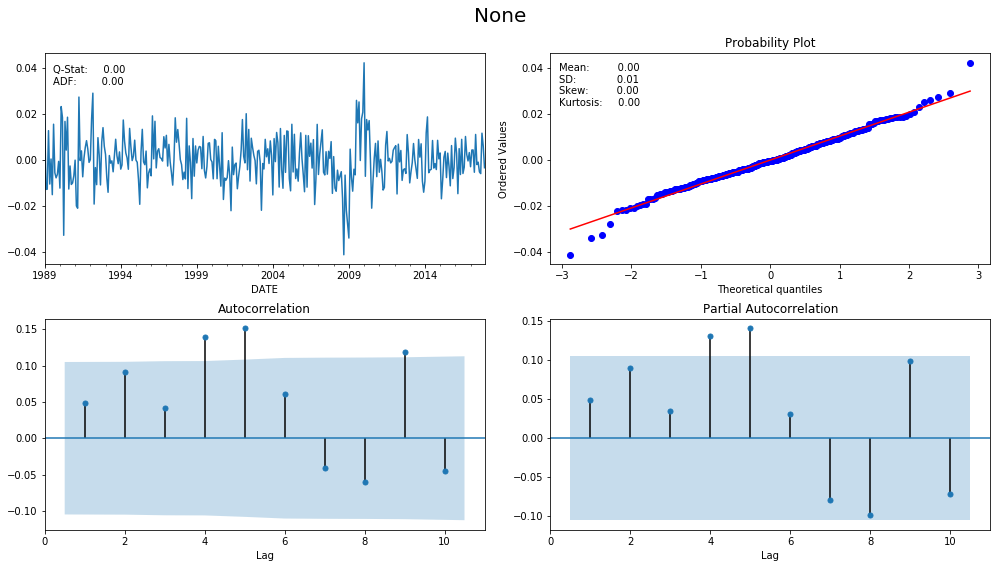

In [36]:
correlogram(model.resid)

## How about SARIMAX?

In [38]:
model = tsa.SARIMAX(endog = industrial_production_log_diff.dropna(), order = (2,0,2),
                    seasonal_order=(1,0,1,12)).fit(start_params = [0,0,0,0,0,0,1])
print(model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                               IPGMFN   No. Observations:                  348
Model:             SARIMAX(2, 0, 2)x(1, 0, [1], 12)   Log Likelihood                1127.913
Date:                              Fri, 28 Feb 2020   AIC                          -2241.826
Time:                                      10:22:34   BIC                          -2214.861
Sample:                                  01-01-1989   HQIC                         -2231.090
                                       - 12-01-2017                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1218      0.431      0.283      0.777      -0.722       0.966
ar.L2          0.86

## Residual Correlogram

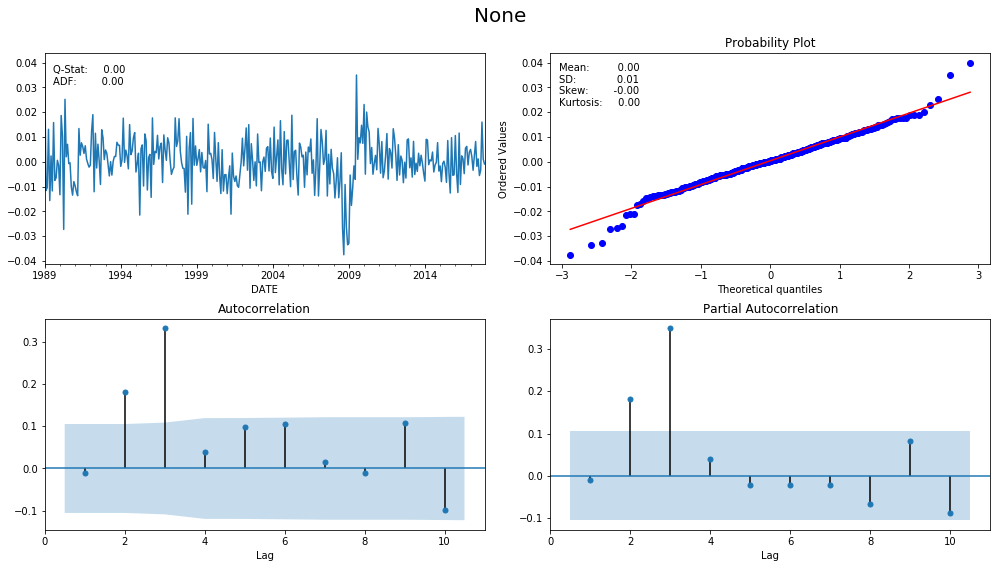

In [39]:
correlogram(model.resid)

In [40]:
train_size = 120 # 10 years of training data
test_results = {}
test_set = industrial_production_log_diff.iloc[train_size:]

for p1 in range(4):
    for q1 in range(4):
        for p2 in range(3):
            for q2 in range(3):
                preds = test_set.copy().to_frame('y_true').assign(y_pred=np.nan)
                aic, bic = [], []
                if p1 == 0 and q1 == 0:
                    continue
                print(p1, q1, p2, q2)
                convergence_error = stationarity_error = 0
                y_pred = []
                for i, T in enumerate(range(train_size, len(industrial_production_log_diff))):
                    train_set = industrial_production_log_diff.iloc[T-train_size:T]
                    try:
                        model = tsa.SARIMAX(endog=train_set,
                                            order=(p1, 0, q1),
                                            seasonal_order=(p2, 0, q2, 12)).fit()
                    except LinAlgError:
                        convergence_error += 1
                    except ValueError:
                        stationarity_error += 1

                    preds.iloc[i, 1] = model.forecast(steps=1)[0]
                    aic.append(model.aic)
                    bic.append(model.bic)
 
                preds.dropna(inplace=True)
                mse = mean_squared_error(preds.y_true, preds.y_pred)
                test_results[(p1, q1, p2, q2)] = [np.sqrt(mse),
                                                  preds.y_true.sub(preds.y_pred).std(),
                                                  np.mean(aic),
                                                  np.std(aic),                                                  
                                                  np.mean(bic),
                                                  np.std(bic),                                                  
                                                  convergence_error,
                                                  stationarity_error]

0 1 0 0
0 1 0 1
0 1 0 2
0 1 1 0
0 1 1 1
0 1 1 2
0 1 2 0
0 1 2 1
0 1 2 2
0 2 0 0
0 2 0 1
0 2 0 2
0 2 1 0
0 2 1 1
0 2 1 2
0 2 2 0
0 2 2 1
0 2 2 2
0 3 0 0
0 3 0 1
0 3 0 2
0 3 1 0
0 3 1 1
0 3 1 2
0 3 2 0
0 3 2 1
0 3 2 2
1 0 0 0
1 0 0 1
1 0 0 2
1 0 1 0
1 0 1 1
1 0 1 2
1 0 2 0
1 0 2 1
1 0 2 2
1 1 0 0
1 1 0 1
1 1 0 2
1 1 1 0
1 1 1 1
1 1 1 2
1 1 2 0
1 1 2 1
1 1 2 2
1 2 0 0
1 2 0 1
1 2 0 2
1 2 1 0
1 2 1 1
1 2 1 2
1 2 2 0
1 2 2 1
1 2 2 2
1 3 0 0
1 3 0 1
1 3 0 2
1 3 1 0
1 3 1 1
1 3 1 2
1 3 2 0
1 3 2 1
1 3 2 2
2 0 0 0
2 0 0 1
2 0 0 2
2 0 1 0
2 0 1 1
2 0 1 2
2 0 2 0
2 0 2 1
2 0 2 2
2 1 0 0
2 1 0 1
2 1 0 2
2 1 1 0
2 1 1 1
2 1 1 2
2 1 2 0
2 1 2 1
2 1 2 2
2 2 0 0
2 2 0 1
2 2 0 2
2 2 1 0
2 2 1 1
2 2 1 2
2 2 2 0
2 2 2 1
2 2 2 2
2 3 0 0
2 3 0 1
2 3 0 2
2 3 1 0
2 3 1 1
2 3 1 2
2 3 2 0
2 3 2 1
2 3 2 2
3 0 0 0
3 0 0 1
3 0 0 2
3 0 1 0
3 0 1 1
3 0 1 2
3 0 2 0
3 0 2 1
3 0 2 2
3 1 0 0
3 1 0 1
3 1 0 2
3 1 1 0
3 1 1 1
3 1 1 2
3 1 2 0
3 1 2 1
3 1 2 2
3 2 0 0
3 2 0 1
3 2 0 2
3 2 1 0
3 2 1 1
3 2 1 2
3 2 2 0
3 2 2 1


### Compare model metrics

In [45]:
test_results = pd.DataFrame(test_results).T
test_results.columns = ['RMSE', 'RMSE_std', 'AIC', 'AIC_std', 'BIC', 'BIC_std', 'convergence', 'stationarity']
test_results['CV'] = test_results.RMSE_std.div(test_results.RMSE)
test_results.index.names = ['p1', 'q1', 'p2', 'q2']
test_results.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 135 entries, (0, 1, 0, 0) to (3, 3, 2, 2)
Data columns (total 9 columns):
RMSE            135 non-null float64
RMSE_std        135 non-null float64
AIC             135 non-null float64
AIC_std         135 non-null float64
BIC             135 non-null float64
BIC_std         135 non-null float64
convergence     135 non-null float64
stationarity    135 non-null float64
CV              135 non-null float64
dtypes: float64(9)
memory usage: 10.5 KB


In [47]:
with pd.HDFStore('time-series-results/arima.h5') as store:
    store.put('arima_results/3', test_results)
    print(store.info())
    df = store.get('arima_results/3')

<class 'pandas.io.pytables.HDFStore'>
File path: time-series-results/arima.h5
/arima_results/3            frame        (shape->[135,9])


In [48]:
df.sort_values('RMSE').head(10)

RMSE  RMSE_std         AIC    AIC_std         BIC    BIC_std  \
p1 q1 p2 q2                                                                     
3  3  1  2   0.008860  0.008879 -775.717538  25.491037 -747.842621  25.491037   
2  3  1  2   0.008905  0.008925 -778.243459  23.074904 -753.156033  23.074904   
3  3  1  1   0.008908  0.008927 -773.728856  23.586842 -748.641430  23.586842   
2  3  1  1   0.009016  0.009031 -776.929431  22.538266 -754.629497  22.538266   
3  2  1  1   0.009110  0.009129 -774.191785  19.593508 -751.891851  19.593508   
2  2  1  2   0.009138  0.009158 -774.481540  18.843303 -752.181606  18.843303   
3  3  2  1   0.009168  0.009188 -771.499683  20.476858 -743.624765  20.476858   
2  3  0  2   0.009171  0.009191 -776.173911  24.540673 -753.873977  24.540673   
   2  1  1   0.009177  0.009195 -773.932810  19.490355 -754.420368  19.490355   
   3  0  1   0.009211  0.009226 -771.616798  31.469753 -752.104356  31.469753   

             convergence  stationarity        CV  
p1 q1 p2 q2                                       
3  3  1  2           2.0           0.0  1.002197  
2  3  1  2           0.0           0.0  1.002197  
3  3  1  1           0.0           0.0  1.002087  
2  3  1  1           0.0           0.0  1.001675  
3  2  1  1           4.0           0.0  1.002112  
2  2  1  2           1.0           0.0  1.002192  
3  3  2  1           2.0           0.0  1.002129  
2  3  0  2           1.0           0.0  1.002152  
   2  1  1           3.0           0.0  1.001933  
   3  0  1           0.0           0.0  1.001721

In [49]:
# Sort values
print(df[['RMSE', 'AIC', 'BIC']].sort_values('RMSE').head())

                 RMSE         AIC         BIC
p1 q1 p2 q2                                  
3  3  1  2   0.008860 -775.717538 -747.842621
2  3  1  2   0.008905 -778.243459 -753.156033
3  3  1  1   0.008908 -773.728856 -748.641430
2  3  1  1   0.009016 -776.929431 -754.629497
3  2  1  1   0.009110 -774.191785 -751.891851


In [50]:
# Spearman correlations
df[['RMSE', 'AIC', 'BIC']].corr('spearman')

,RMSE,AIC,BIC
RMSE,1.000000,0.964813,0.894922
AIC,0.964813,1.000000,0.925915
BIC,0.894922,0.925915,1.000000


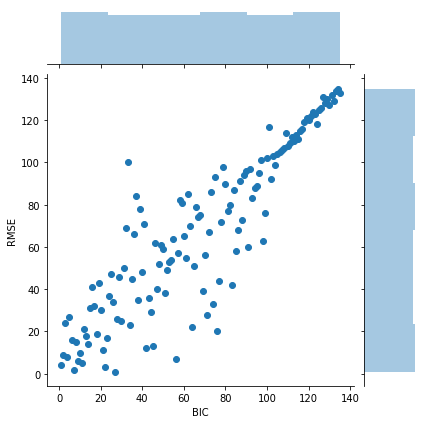

In [51]:
# Seaborn's jointplot
sns.jointplot(y = 'RMSE', x = 'BIC', data = df[['RMSE', 'BIC']].rank())
plt.show()

In [52]:
df[(df.RMSE < df.RMSE.quantile(.05)) & (df.BIC < df.BIC.quantile(.1))]

RMSE  RMSE_std         AIC    AIC_std         BIC    BIC_std  \
p1 q1 p2 q2                                                                     
2  2  1  2   0.009138  0.009158 -774.481540  18.843303 -752.181606  18.843303   
   3  1  1   0.009016  0.009031 -776.929431  22.538266 -754.629497  22.538266   
         2   0.008905  0.008925 -778.243459  23.074904 -753.156033  23.074904   
3  2  1  1   0.009110  0.009129 -774.191785  19.593508 -751.891851  19.593508   

             convergence  stationarity        CV  
p1 q1 p2 q2                                       
2  2  1  2           1.0           0.0  1.002192  
   3  1  1           0.0           0.0  1.001675  
         2           0.0           0.0  1.002197  
3  2  1  1           4.0           0.0  1.002112

## Train the best SARIMAX model

In [58]:
best_sar = tsa.SARIMAX(endog = industrial_production_log_diff, order = (2,0,2),
                       seasonal_order = (1,2,2,12)).fit()
print(best_sar.summary())

                                     SARIMAX Results                                      
Dep. Variable:                             IPGMFN   No. Observations:                  348
Model:             SARIMAX(2, 0, 2)x(1, 2, 2, 12)   Log Likelihood                 976.430
Date:                            Fri, 28 Feb 2020   AIC                          -1936.860
Time:                                    15:04:16   BIC                          -1906.614
Sample:                                01-01-1989   HQIC                         -1924.787
                                     - 12-01-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5313      0.076     20.067      0.000       1.382       1.681
ar.L2         -0.5522      0.076   

## Residual Correlogram

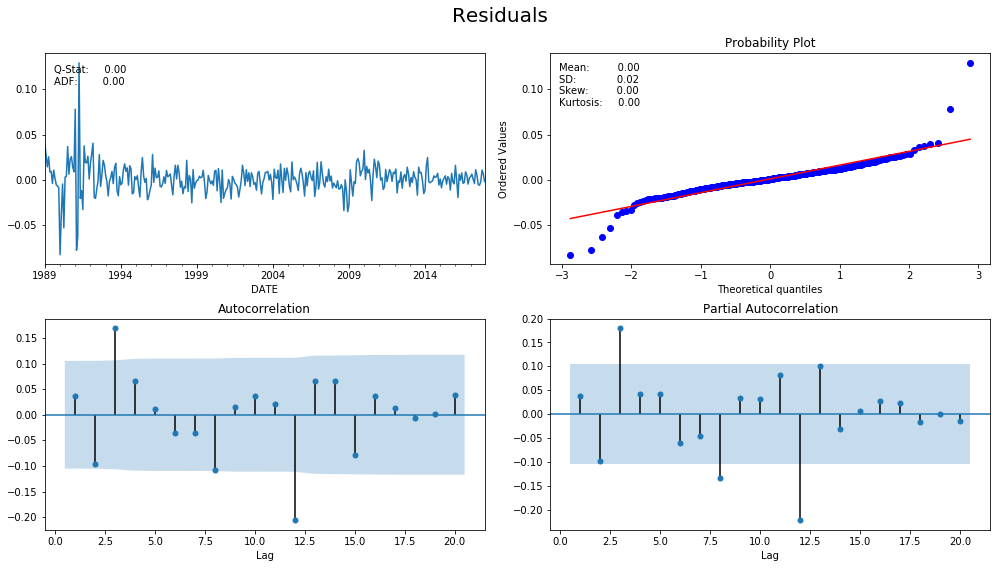

In [59]:
correlogram(best_sar.resid, lags = 20, title = "Residuals")